# Multivariate response model 

Machine information 

In [4]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)


## Demo data

For demonstration, we generate a random data set. We use the following distribution to generate response $Y$ of size $100 \times 3$:

$$Y \sim \text{Normal}(X\beta, \Sigma_1 \otimes V_1 + \cdots + \Sigma_{10}\otimes V_{10} + \Sigma_0 \otimes I_n)$$

where $\otimes$ indicates Kronecker product and each $\Sigma_i$ indicates variance component for $i$-th group, $i=0,1,\ldots, 10.$ We set  

$$\Sigma_i = \begin{cases} 1.5 \mathbf{I}_{100} & \text{ if } i=1,4,10 \\
                            \mathbf{I}_{100} & \text{ if } i=0 \\ 
                                \mathbf{0}& \text{ else. } \end{cases}$$

Define $\Omega = \text{Var}(Y) = \Sigma_1 \otimes V_1 + \cdots + \Sigma_{10} \otimes V_{10} + \Sigma_0\otimes I_n.$ The covariate matrix $X$ is generated using standard normal distribution. 



In [1]:
using LinearAlgebra, Random

## generate data from a d-variate response variance component model
Random.seed!(123)
n = 100          # no. observations
d = 3            # no. categories
m = 11           # no. variance components
p = 4            # no. covariates
X = randn(n, p)  # n-by-p covariate matrix 
β = ones(p, d)   # p-by-d mean component regression coefficient 

# a vector of d-by-d variance component parameters 
Σ = [zeros(d, d) for i in 1:m]
for i in [1, 4, 10]
  Σ[i] = 1.5 * Matrix{Float64}(I, d, d)
end
Σ[end] = Matrix{Float64}(I, d, d)

# a vector of covariance matrices 
V  = Array{Matrix{Float64}}(undef, m)
for i = 1:(m - 1)
  Zi = randn(n, 50)
  V[i] =  Zi * Zi'
  V[i] ./= norm(V[i])
end
V[end] = Matrix(I, n, n) ./ √n

# form overall nd-by-nd covariance matrix Ω
Ω = zeros(n*d, n*d)
for i = 1:m
    Ω .+= kron(Σ[i], V[i])
end
Ωchol = cholesky!(Symmetric(Ω))

# n-by-d responses
Y = X * β + reshape(Ωchol.L * randn(n*d), n, d);

True variance component parameter vector:

In [2]:
Σ

11-element Array{Array{Float64,2},1}:
 [1.5 0.0 0.0; 0.0 1.5 0.0; 0.0 0.0 1.5]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [1.5 0.0 0.0; 0.0 1.5 0.0; 0.0 0.0 1.5]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [1.5 0.0 0.0; 0.0 1.5 0.0; 0.0 0.0 1.5]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

## Goal

Suppose we wish to select $\Sigma_i$ that are associated with response $Y$ (among $i=1,\ldots, 10$). This can be achieved by `VCSEL.jl` package. 

!!! note
    
    Note that we do not select $\Sigma_0$. We consider this to be the intercept variance component. 

## Variance component selection

First load the package.

In [3]:
using VCSEL

To perform selection, take 2 steps:

**Step 1 (Construct a model)**. Construct an instance of `VCModel`, which is the fundamental type for variance component model. It includes fields 

* `Y`: $n$-by-$d$ responses. 
* `X`: $n$-by-$p$ covariate matrix (if exists).
* `V=[V[1],...,V[m],I]`: a vector of $n$-by-$n$ covariance matrices. The last covariance matrix must be positive definite and usually is a diagonal matrix. **All `V[i]` should have frobenius norm 1.**
* `Σ=[Σ[1],...,Σ[m],Σ[0]]`: a vector of initial estimates for $d$-by-$d$ variance component parameters. When $d=1$, `Σ` is a $m+1$-by-$1$ vector of scalars. If not supplied, it is set to be a vector of $d$-by-$d$ identity matrix by default (or vector of 1's if $d=1$). 

!!! note 

    All `V[i]` should have frobenius norm 1. This is easily achievable by `V[i] = V[i] / norm(V[i])`.

`VCModel` can be initialized by 

```julia
VCModel(Y, V)
VCModel(Y, V, Σ)
VCModel(Y, X, V)
VCModel(Y, X, V, Σ)
```

Let us construct a `VCModel` using `Y`, `X`, and `V`. Since we do not provide `Σ`, it is initialized to be a vector of identity matrices. 

In [4]:
vcm = VCModel(Y, X, V);

Note that every element of initial estimates for `Σ` is an identity matrix. 

In [5]:
vcm.Σ

11-element Array{Array{Float64,2},1}:
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

**Step 2 (Optimize)**. Call optimization routine `vcselect!`. 

Required input argument for executing `vcselect!` is:
    
- `VCModel`.

Keyword Arguments are 

- `penfun`: penalty function. Default is `NoPenalty()`. Other options are `L1Penalty()` and `MCPPenalty()`.
- `λ`: tuning parameter. Default is 1.0.    
- `penwt`: penalty weights. Default is (1,...1,0).
- `standardize`: logical flag for covariance matrix standardization. Default is `false`.
    If true, `V[i]` is standardized by its Frobenius norm, and parameter estimates are 
    returned on the original scale.
- `maxiters`: maximum number of iterations. Default is 1000.
- `tol`: convergence tolerance. Default is `1e-5`.
- `verbose`: display switch. Default is false.
- `checktype`: check argument type switch. Default is true.

<a id='no-penalty'></a>
### No penalty 

First, we call `vcselect!` without specifying any penalty function. By default, it is fit with no penalty (i.e. $\lambda=0$).

In [6]:
vcm_nopen = deepcopy(vcm);
vcm_nopen, final_obj, niters, = vcselect!(vcm_nopen);
## equivalent to 
# vcselect!(vcm_nopen; penfun=NoPenalty());
# vcselect!(vcm_nopen; λ=0.0)

(VCModel{Float64}([1.860094835353257 2.055403434516128 2.84544587051332; 3.4359556067573895 2.8421454064488842 2.860512418851407; … ; -0.21488508947517132 -0.3336880873733919 0.3849750333444425; -2.7580470886596755 -3.400050457633945 -4.784333938275772], [1.1902678809862768 0.3762642112434747 0.34658945360812454 0.45809880324835406; 2.04817970778924 -0.4052717901213415 1.604313725337457 0.13912437753868148; … ; -0.16371133936712523 0.5752786905523419 -0.17655459673142 -0.045725895200926625; -0.9029858060964956 -0.16600120902535137 -1.2792370363858774 -1.3123821810547711], [[0.092494023125743 0.0030042568249118926 … -0.00922398515864249 0.013285729616217755; 0.0030042568249118926 0.04025705934773749 … 0.003708804177337504 0.003823593679063355; … ; -0.00922398515864249 0.003708804177337504 … 0.039439277698925315 0.001178066910649526; 0.013285729616217755 0.003823593679063355 … 0.001178066910649526 0.06886830969476362], [0.06030328209283304 -0.001024446424453263 … 0.002416656153804365 0.0

The output of `vcselect!` contains 

* fitted model 

In [8]:
vcm_nopen;

Parameter estimates can be accessed as below:

* estimated variance components 

In [7]:
# variance components
vcm_nopen.Σ 

11-element Array{Array{Float64,2},1}:
 [1.040392519682894 -0.9331650013274756 0.2698792614971673; -0.9331650013274755 1.8323672344949145 0.5027515826645772; 0.2698792614971673 0.5027515826645772 0.6285554861339957]
 [1.022164010367449 -0.40348987265201536 -0.32127925630485177; -0.40348987265201547 0.15944226901597186 0.12680764831035088; -0.3212792563048518 0.12680764831035088 0.10098342437882002]
 [0.04652475933325329 -0.15955065387098033 -0.09119883427438784; -0.15955065387098036 0.558496540875567 0.31799201475835637; -0.09119883427438785 0.31799201475835637 0.18118920760059967]
 [0.3345667575960278 0.8714891952837133 -0.4085346910999654; 0.8714891952837132 2.283405973643672 -1.2403652975256347; -0.4085346910999654 -1.240365297525635 2.8288133260307773]
 [0.9234821871351467 -0.497494817604588 -0.02358520286780985; -0.4974948176045879 0.26800851998962266 0.012705734095699441; -0.02358520286780985 0.012705734095699441 0.0006023662559145914]
 [0.5212700918589973 -0.3487119661493774 0.20

* estimated mean regression coefficients 

In [14]:
vcm_nopen.β 

4×3 Array{Float64,2}:
 0.982624  0.993886  1.02794
 0.978163  1.02323   0.971143
 0.925411  1.01458   0.898839
 0.868534  1.1076    1.02098

* estimated ``nd\times nd`` overall covariance matrix 

In [15]:
vcm_nopen.Ωest 

300×300 Array{Float64,2}:
  0.404642      0.0212995    -0.0439677    …  -0.000996711   0.00924459
  0.0212995     0.297675     -0.0225235       -0.00142137   -0.00429534
 -0.0439677    -0.0225235     0.355902         0.00217228    0.0148259
  0.0141434     0.0137725    -0.00278179       0.00270504    0.00310854
  0.00204811   -0.028574      0.00272162      -0.00533976   -0.000170068
  0.00778168   -0.0246549     0.0214009    …  -0.00351548    0.00481182
  0.0214074     0.00720804   -0.0188076        0.00458159    0.00200145
  0.0212846    -0.0168359     0.0235598       -0.00940152   -0.00161028
  0.00027726   -0.00359327    0.0120295        0.0124774    -0.00456738
  0.0333097     0.00505554   -0.00798919      -0.00368395    0.00712723
  0.0337032     0.0174631     0.0144735    …  -0.00782776    0.00526143
  0.00168991    0.0105267    -0.0387361        0.000699345  -0.0126745
  0.0497327    -0.000448481   0.00476156      -0.00570844    0.00561756
  ⋮                                    

* final objective value

In [10]:
final_obj

224.08353228995801

* number of iterations to convergence

In [11]:
niters

276

### Selection at specific regularization parameter 

Now we specify penalty function `penfun=L1Penalty()` and regularization parameter value `λ=2.0`. 

In [12]:
vcm_L1 = deepcopy(vcm)
vcm_L1, obj_L1, niters_L1, = vcselect!(vcm_L1; penfun=L1Penalty(), λ=2.0);

* Estimated variance components

In [13]:
vcm_L1.Σ

11-element Array{Array{Float64,2},1}:
 [0.723344411461242 -0.5371552915924754 0.2653186252185347; -0.5371552915924754 1.4582908604350255 0.5524782606904559; 0.2653186252185347 0.5524782606904559 0.6325518383029696]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.057805236800426145 -0.17358417446955493 -0.10897979851692789; -0.17358417446955496 0.5212600756188006 0.32725770158442874; -0.1089797985169279 0.32725770158442874 0.20545912804073208]
 [0.2913469143855766 0.7770359938857069 -0.4247453010516808; 0.7770359938857069 2.0730922239946166 -1.1687134116436118; -0.42474530105168085 -1.168713411643612 2.474665577830677]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.06642785873460767 -0.0838719932120693 -0.14527412016886251; -0.0838719932120693 0.11376962987090039 0.22138651825918587; -0.14527412016886251 0.22138651825918582 0.5007706483133327]
 [1.2155752663079227 0.7538

* Estimated mean regression coefficients

In [17]:
vcm_L1.β

4×3 Array{Float64,2}:
 1.03872   0.939329  0.975904
 0.993807  0.997929  0.969196
 0.951591  1.03716   0.887175
 0.910584  1.05514   1.07108

* Objective value at the last iteration 

In [18]:
obj_L1

246.1242780263884

* Number of iterations taken to reach convergence

In [19]:
niters_L1

135

## Obtain solution path 

`vcselectpath!` function to compute regularization path for a given penalty at a grid of the regularization parameter lambda values. `vcselectpath!` provides options for users to customize. Keyword arguments for the function are 

- `penfun`: penalty function (e.g. `NoPenalty()`, `L1Penalty()`, `MCPPenalty()`). Default is `NoPenalty()`.
- `penwt`: weights for penalty term. Default is (1,1,...1,0).
- `nλ`: number of `λ` values in the sequence. Default is 100. 
- `λpath`: user-provided sequence of `λ` values in ascending order. Typically the program computes its own `λ` sequence based on `nλ`, but supplying `λpath` overrides this.
- `maxiter`: maximum number of iteration for MM loop. Default is 1000.
- `standardize`: logical flag for covariance matrix standardization. Default is `false`. If true, `V[i]` is standardized by its Frobenius norm.
- `tol`: convergence tolerance. Default is `1e-6`.

### No penalty

When called without any penalty, `vcselectpath!` returns the same output as `vcselect!` with `penfun=NoPenalty()` ([compare the output](#no-penalty)). 

In [16]:
vcmpath_np = deepcopy(vcm)
Σ̂path_np, β̂path_np, λpath_np, objpath_np, niterspath_np = vcselectpath!(vcmpath_np);

* Estimated variance components at $\lambda=0$

In [17]:
Σ̂path_np

11-element Array{Array{Float64,2},1}:
 [1.040392519682894 -0.9331650013274756 0.2698792614971673; -0.9331650013274755 1.8323672344949145 0.5027515826645772; 0.2698792614971673 0.5027515826645772 0.6285554861339957]
 [1.022164010367449 -0.40348987265201536 -0.32127925630485177; -0.40348987265201547 0.15944226901597186 0.12680764831035088; -0.3212792563048518 0.12680764831035088 0.10098342437882002]
 [0.04652475933325329 -0.15955065387098033 -0.09119883427438784; -0.15955065387098036 0.558496540875567 0.31799201475835637; -0.09119883427438785 0.31799201475835637 0.18118920760059967]
 [0.3345667575960278 0.8714891952837133 -0.4085346910999654; 0.8714891952837132 2.283405973643672 -1.2403652975256347; -0.4085346910999654 -1.240365297525635 2.8288133260307773]
 [0.9234821871351467 -0.497494817604588 -0.02358520286780985; -0.4974948176045879 0.26800851998962266 0.012705734095699441; -0.02358520286780985 0.012705734095699441 0.0006023662559145914]
 [0.5212700918589973 -0.3487119661493774 0.20

* Estimated mean regression cofficients

In [22]:
β̂path_np

4×3 Array{Float64,2}:
 0.982624  0.993886  1.02794
 0.978163  1.02323   0.971143
 0.925411  1.01458   0.898839
 0.868534  1.1076    1.02098

### lasso (L1) penalty

Now let us call `vcselectpath!` with `penfun=L1Penalty()`. Since we do not provide `nλ` or `λpath`, a grid of 100 $λ$ values is generated internally. 

In [18]:
vcm_path = deepcopy(vcm)
Σ̂path, β̂path, λpath, objpath, niterspath = vcselectpath!(vcm_path; 
    penfun=L1Penalty());

Output of `vcselectpath!` include

* variance component parameters path: $(i,j)$-th element corresponds to $i$-th variance component matrix at `λpath[j]`, $i=1,\ldots, 10, \; j=1,\ldots, 100$. The last row is for the intercept variance component $\Sigma_0.$ 

In [19]:
Σ̂path

11×100 Array{Array{Float64,2},2}:
 [1.04039 -0.933165 0.269879; -0.933165 1.83237 0.502752; 0.269879 0.502752 0.628555]                       …  [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [1.02216 -0.40349 -0.321279; -0.40349 0.159442 0.126808; -0.321279 0.126808 0.100983]                         [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0465248 -0.159551 -0.0911988; -0.159551 0.558497 0.317992; -0.0911988 0.317992 0.181189]                   [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.334567 0.871489 -0.408535; 0.871489 2.28341 -1.24037; -0.408535 -1.24037 2.82881]                          [0.0174472 0.0536601 -0.129907; 0.0536601 0.165207 -0.401806; -0.129907 -0.401806 0.99725]
 [0.923482 -0.497495 -0.0235852; -0.497495 0.268009 0.0127057; -0.0235852 0.0127057 0.000602366]               [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.52127 -0.348712 0.206522; -0.348712 0.861941 0.277715; 0.206522 0.277715 0.356984]                      …  [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.33030

Let's take a trace of each variance component matrix:

In [20]:
tr.(Σ̂path)

11×100 Array{Float64,2}:
 3.50132     3.48511     3.46942      …  0.0      0.0      0.0      0.0
 1.28259     1.27383     1.26476         0.0      0.0      0.0      0.0
 0.786211    0.778599    0.767317        0.0      0.0      0.0      0.0
 5.44679     5.42393     5.40053         1.23521  1.21661  1.19738  1.1799
 1.19209     1.18283     1.16928         0.0      0.0      0.0      0.0
 1.7402      1.73267     1.72395      …  0.0      0.0      0.0      0.0
 0.741877    0.737532    0.732446        0.0      0.0      0.0      0.0
 4.63223e-6  4.43571e-8  1.30524e-27     0.0      0.0      0.0      0.0
 2.02336     2.01271     2.00308         0.0      0.0      0.0      0.0
 3.84354     3.82467     3.80531         0.0      0.0      0.0      0.0
 0.016773    0.0168316   0.0172408    …  1.05895  1.06013  1.06136  1.06244

* mean regression coefficient path: $j$-th element in `β̂path` corresponds to ``p \times d`` matrix at `λpath[j]`.

In [21]:
β̂path

100-element Array{Array{Float64,2},1}:
 [0.98262373057086 0.9938855069481529 1.0279389406903463; 0.9781630466475704 1.0232304476367446 0.9711430902302547; 0.925410633551665 1.0145769598392573 0.8988391195993317; 0.8685338679504442 1.1075976421283704 1.0209845293559523]
 [0.9826723741438449 0.9938411671049736 1.0279441554165234; 0.9781681244718433 1.0232195083930147 0.9711200008594976; 0.9254769069363215 1.0145067824010234 0.8987990903897921; 0.8684971520201659 1.1076188419049282 1.0210127281549157]
 [0.9827321508014188 0.9938006170968411 1.0279449191189431; 0.9780982837575499 1.0232404991539605 0.9711011198556062; 0.9255516761234288 1.0143657102605843 0.8987031231587199; 0.8684816773490761 1.1076609038453296 1.0210783284673182]
 [0.9827903631844511 0.9938125529695944 1.0279330735978551; 0.9778659114213134 1.0233348790084396 0.9711154851460205; 0.9255869891688436 1.0141612563651003 0.8985456829295271; 0.8684867250543918 1.1077384865908064 1.0212059478437578]
 [0.9828615218423427 0.99383

* grid of $\lambda$ values used 

In [22]:
λpath 

0.0:0.10741136572135104:10.633725206413754

* final objective values at each $\lambda$

In [23]:
objpath

100-element Array{Float64,1}:
 224.08353228995801
 225.46380975526435
 226.83913668625473
 228.20752546238006
 229.56990311430656
 230.92627105967046
 232.27644640990817
 233.61993238399796
 234.95500162870488
 236.26376004751847
 237.56020520808107
 238.85634517206825
 240.1437071565822
   ⋮
 274.3013488002825
 274.42499927491315
 274.54709707460023
 274.66811929173605
 274.78827594135294
 274.90775183788725
 275.02667147568206
 275.14483602625654
 275.26231439618005
 275.37913594007694
 275.49504103218504
 275.6103295944747

* number of iterations taken to converge at each $\lambda$

In [28]:
niterspath

100-element Array{Int64,1}:
 276
   6
   9
  17
  19
  20
  21
  23
  30
 101
  89
  52
  48
   ⋮
  18
  19
  18
  16
  14
  12
  10
   9
   8
   7
   7
   6

To get the order in which variance components entered the solution path, we use `rankvarcomps` function:

In [26]:
posvarcomps, zerovarcomps = rankvarcomps(Σ̂path)

([4, 10, 1, 9, 6, 2, 7, 5, 3, 8], [11])

Note that output includes two vectors. The first vector `posvarcomps` displays indices of variance components in the order they entered the solution path; the second vector `zerovarcomps` shows indices of those that are zero (except when $\lambda=0)$ and residual variance component, in no particular order. 

In [27]:
posvarcomps

10-element Array{Int64,1}:
  4
 10
  1
  9
  6
  2
  7
  5
  3
  8

In [31]:
zerovarcomps

1-element Array{Int64,1}:
 11

## Visualize/summarize

We can visualize `Σ̂path` via `plotsolpath` function. 
When variance component parameter is a matrix, `plotsolpath` calculates its trace and plots trace values at each $\lambda$. 



Required arguments of `plotsolfunction` are

* `Σ̂path`: solution path generated from `vcselectpath!`
* `λpath`: grid of $\lambda$ values used for `Σ̂path`.

Keyword arguemnts are 

- `title`: title of the figure. Default is "Solution Path".
- `xlab`: x-axis label. Default is "$\lambda$".
- `ylab`: y-axis label. Default is "$\sigma^2$" or "trace$(\Sigma)$".
- `xmin`: lower limit for x-axis. Default is minimum of `λpath`.
- `xmax`: upper limit for x-axis. Default is maximum of `λpath`.
- `linewidth`: line width. Default is 1.0.
- `nranks`: no. of ranks to displayed on legend. Default is total number of variance components.
- `legend`: logical flag for including legend. Default is true.
- `legendout`: logical flag for moving the legend outside the plot. Default is true. 
- `legendtitle`: legend title. Default is "Ranking". 
- `resvarcomp`: logical flag for indicating residual variance component in `σ2path`. Default is true. 

Resulting plot includes a legend, which displays the order variance components enter the solution path. Here we use `legendout=false` option to place the legend within the figure. 

We exclude the last variance component (residual variance component) from the solution path:

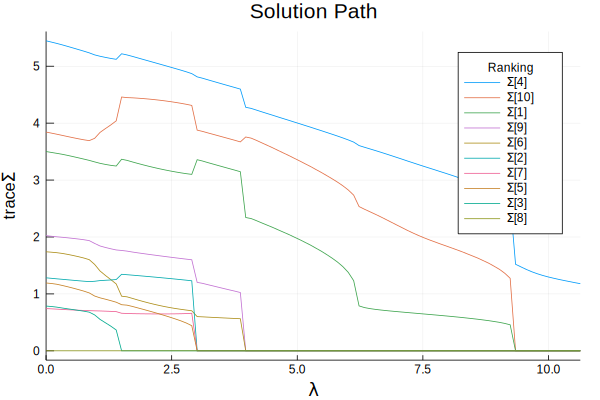

In [24]:
plotsolpath(Σ̂path[1:end-1, :], λpath; legendout=false, resvarcomp=false, 
    ylab="trace\\Sigma")

Note the ranking in the legend matches that from `rankvarcomps`.

In [28]:
posvarcomps

10-element Array{Int64,1}:
  4
 10
  1
  9
  6
  2
  7
  5
  3
  8